In [3]:
import sys
sys.path.append("../../src/earthtext")

from osm import osm
import os
import geopandas as gpd
import pandas as pd
from progressbar import progressbar as pbar
import numpy as np
from pyproj import CRS
import shapely as sh
import geoplot as gplt
epsg4326 = CRS.from_epsg(4326)
epsg_california = CRS.from_epsg(26946)


In [4]:
from glob import glob

scenes_folder = "/opt/data/california-naip-defs"

In [5]:
files = list(glob(f'{scenes_folder}/**/*.parquet', recursive=True))
len(files)

1267

# sample chips for each scene

In [6]:
total_target_chips = 200000
samples_per_file = total_target_chips // len(files)
samples_per_file

157

In [7]:
total_naip_chips = sum([len(gpd.read_parquet(file)) for file in pbar(files)])
total_naip_chips

100% (1267 of 1267) |####################| Elapsed Time: 0:01:02 Time:  0:01:020005


2394599

In [204]:
samples = pd.concat([gpd.read_parquet(file).sample(samples_per_file) for file in pbar(files)])
samples.crs = epsg4326

100% (1267 of 1267) |####################| Elapsed Time: 0:01:28 Time:  0:01:280007


In [205]:
samples.head()

,chipid,date,chip_index_x,chip_index_y,cloud_cover_percentage,nodata_percentage,geometry,embeddings
227,ca_m_3311601_ne_11_060_20220506-27-5,2022-05-06,27,5,0.0,0.0,"POLYGON ((-116.89310 33.99492, -116.89310 33.9...","[-0.13333216, 0.0399988, 0.14124717, 0.0125191..."
984,ca_m_3311601_ne_11_060_20220506-24-24,2022-05-06,24,24,0.0,0.0,"POLYGON ((-116.89812 33.96860, -116.89812 33.9...","[-0.1470401, 0.026783561, 0.12910064, 0.014626..."
259,ca_m_3311601_ne_11_060_20220506-19-6,2022-05-06,19,6,0.0,0.0,"POLYGON ((-116.90640 33.99355, -116.90641 33.9...","[-0.14139079, 0.021682426, 0.14206946, 0.00693..."
30,ca_m_3311601_ne_11_060_20220506-30-0,2022-05-06,30,0,0.0,0.0,"POLYGON ((-116.88810 34.00184, -116.88810 34.0...","[-0.10461623, 0.033646498, 0.115653, 0.0179855..."
989,ca_m_3311601_ne_11_060_20220506-29-24,2022-05-06,29,24,0.0,0.0,"POLYGON ((-116.88981 33.96860, -116.88981 33.9...","[-0.13561213, 0.03594061, 0.12552005, 0.009031..."


# visualize coverage of sampled chips

In [206]:
g = samples.geometry.values[0]
for gi in pbar(samples.geometry.values):
    g = g.union(gi).convex_hull

100% (198919 of 198919) |################| Elapsed Time: 0:00:09 Time:  0:00:090000


In [207]:
gpd.GeoDataFrame([[g]], columns=['geometry'], crs=epsg4326).explore()

# spatial distribution of sampled chips

<Axes: >

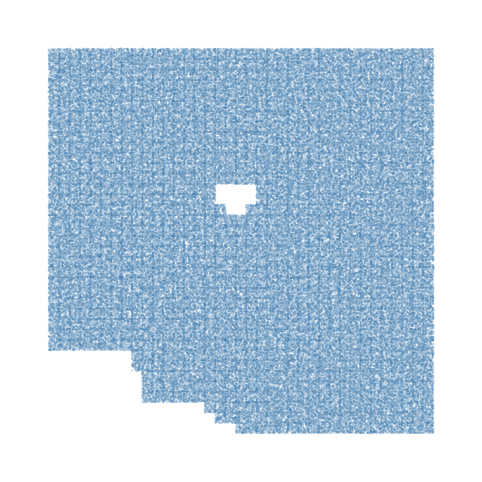

In [209]:
z = samples.copy()
z['geometry'] = [i.centroid for i in z.geometry]
gplt.pointplot(z, s=0.1)


# save file

In [211]:
# arrange index
samples['original_chip_id'] = samples['chipid']
del(samples['chipid'])
samples['chip_id'] = [osm.get_region_hash(gi) for gi in pbar(samples.geometry.values)]
samples.set_index('chip_id', inplace=True)


100% (198919 of 198919) |################| Elapsed Time: 0:00:30 Time:  0:00:300002


In [212]:
samples.head()

,date,chip_index_x,chip_index_y,cloud_cover_percentage,nodata_percentage,geometry,embeddings,original_chip_id
chip_id,,,,,,,,
3416f3c464df4,2022-05-06,27,5,0.0,0.0,"POLYGON ((-116.89310 33.99492, -116.89310 33.9...","[-0.13333216, 0.0399988, 0.14124717, 0.0125191...",ca_m_3311601_ne_11_060_20220506-27-5
22fdfb499b95a,2022-05-06,24,24,0.0,0.0,"POLYGON ((-116.89812 33.96860, -116.89812 33.9...","[-0.1470401, 0.026783561, 0.12910064, 0.014626...",ca_m_3311601_ne_11_060_20220506-24-24
06e39238c16ee,2022-05-06,19,6,0.0,0.0,"POLYGON ((-116.90640 33.99355, -116.90641 33.9...","[-0.14139079, 0.021682426, 0.14206946, 0.00693...",ca_m_3311601_ne_11_060_20220506-19-6
108471e507d4c,2022-05-06,30,0,0.0,0.0,"POLYGON ((-116.88810 34.00184, -116.88810 34.0...","[-0.10461623, 0.033646498, 0.115653, 0.0179855...",ca_m_3311601_ne_11_060_20220506-30-0
16dd360b58af6,2022-05-06,29,24,0.0,0.0,"POLYGON ((-116.88981 33.96860, -116.88981 33.9...","[-0.13561213, 0.03594061, 0.12552005, 0.009031...",ca_m_3311601_ne_11_060_20220506-29-24


In [213]:
samples.to_parquet("/opt/data/california-naip-chips/california-naip-chips-200k-raw.parquet")